# PySpark Data Analysis Notebook

This notebook follows the requested steps:

- **STEP 1:** Load Libraries & Data
- **STEP 2:** Data Cleaning
- **STEP 3:** Analytics
- **STEP 4:** Convert to Pandas for Visualization (Improved)
- **STEP 5:** Recommendations (Simple Rules)

**Data file provided:** `9ef84268-d588-465a-a308-a864a43d0070.csv`

> The notebook prefers running with PySpark available. If PySpark is not installed in your environment, the cells include a pandas fallback so you can still run the analysis locally.


In [1]:
# STEP 1: Load Libraries & Data

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim, when, isnan, count, length
spark = SparkSession.builder.appName("PySparkAnalysis").getOrCreate()
df = spark.read.options(header=True, inferSchema=True, multiLine=True, escape='"').csv("9ef84268-d588-465a-a308-a864a43d0070.csv")
print("Loaded DataFrame (Spark) with %d rows and %d columns" % (df.count(), len(df.columns)))
display(df.limit(5))

Loaded DataFrame (Spark) with 16039 rows and 10 columns


DataFrame[State: string, District: string, Market: string, Commodity: string, Variety: string, Grade: string, Arrival_Date: string, Min_x0020_Price: double, Max_x0020_Price: double, Modal_x0020_Price: double]

In [4]:
# STEP 2: Data Cleaning
# Generic cleaning steps:
#  - Trim whitespace on string columns
#  - Drop exact duplicate rows
#  - Report missing values

from pyspark.sql.functions import col, trim, when, isnan, count, length

# Trim all string columns
string_cols = [f.name for f in df.schema.fields if str(f.dataType) == 'StringType']
for sc in string_cols:
    df = df.withColumn(sc, trim(col(sc)))

# Drop exact duplicates
df = df.dropDuplicates()

# Count missing or null entries per column
missing_counts = df.select([
    count(
        when(col(c).isNull() | (trim(col(c).cast("string")) == ""), c)
    ).alias(c)
    for c in df.columns
])

print("Missing / empty counts:")
display(missing_counts.toPandas())

print("Schema after cleaning:")
df.printSchema()

# Optional: show a few cleaned records
display(df.limit(5))


Missing / empty counts:


,State,District,Market,Commodity,Variety,Grade,Arrival_Date,Min_x0020_Price,Max_x0020_Price,Modal_x0020_Price
0,0,0,0,0,0,0,0,0,0,0


Schema after cleaning:
root
 |-- State: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Market: string (nullable = true)
 |-- Commodity: string (nullable = true)
 |-- Variety: string (nullable = true)
 |-- Grade: string (nullable = true)
 |-- Arrival_Date: string (nullable = true)
 |-- Min_x0020_Price: double (nullable = true)
 |-- Max_x0020_Price: double (nullable = true)
 |-- Modal_x0020_Price: double (nullable = true)



DataFrame[State: string, District: string, Market: string, Commodity: string, Variety: string, Grade: string, Arrival_Date: string, Min_x0020_Price: double, Max_x0020_Price: double, Modal_x0020_Price: double]

In [5]:
# STEP 3: Analytics
# Provide useful analytics: summary statistics, top categories, and basic insights.

from pyspark.sql.functions import col, desc, count, mean, min, max, avg

print("=== 1. Basic Summary Statistics for Numeric Columns ===")
display(df.describe().toPandas())

print("=== 2. Top 10 Values for Each String (Categorical) Column ===")
for c in df.columns:
    if dict(df.dtypes)[c] == "string":
        print(f"\nTop values for {c}:")
        display(
            df.groupBy(c)
              .count()
              .orderBy(desc("count"))
              .limit(10)
              .toPandas()
        )

print("=== 3. Count of Nulls/Empty per Column ===")
from pyspark.sql.functions import when, isnan, length
missing_counts = df.select([
    count(when(col(c).isNull() | (length(col(c)) == 0), c)).alias(c)
    for c in df.columns
])
display(missing_counts.toPandas())

print("=== 4. Correlation Between Numeric Columns (if any) ===")
numeric_cols = [f.name for f in df.schema.fields if "DoubleType" in str(f.dataType) or "LongType" in str(f.dataType) or "IntegerType" in str(f.dataType)]
if len(numeric_cols) > 1:
    for i in range(len(numeric_cols)):
        for j in range(i + 1, len(numeric_cols)):
            corr_val = df.stat.corr(numeric_cols[i], numeric_cols[j])
            print(f"Correlation between {numeric_cols[i]} and {numeric_cols[j]}: {corr_val:.3f}")
else:
    print("Not enough numeric columns to compute correlations.")

print("=== 5. Overall Row and Column Counts ===")
row_count = df.count()
col_count = len(df.columns)
print(f"Total Rows: {row_count}, Total Columns: {col_count}")

print("=== 6. Top 5 Numeric Columns by Average Value ===")
if numeric_cols:
    numeric_summary = (
        df.select([avg(col(c)).alias(c) for c in numeric_cols])
          .toPandas()
          .T
          .reset_index()
          .rename(columns={"index": "Column", 0: "Average_Value"})
          .sort_values("Average_Value", ascending=False)
          .head(5)
    )
    display(numeric_summary)
else:
    print("No numeric columns found to compute averages.")

=== 1. Basic Summary Statistics for Numeric Columns ===


,summary,State,District,Market,Commodity,Variety,Grade,Arrival_Date,Min_x0020_Price,Max_x0020_Price,Modal_x0020_Price
0,count,16039,16039,16039,16039,16039,16039,16039,16039,16039,16039
1,mean,None,None,None,None,1055.7692307692307,None,None,4060.7165346966767,4764.492939085978,4551.684079431387
2,stddev,None,None,None,None,62.86248728528252,None,None,4362.812497623204,4864.355785756522,4732.0516973161675
3,min,Andhra Pradesh,Jhunjhunu,A lot,Ajwan,(Red Nanital),FAQ,06/10/2025,0.0,0.0,2.0
4,max,West Bengal,kapurthala,vadakarapathy,nigella seeds,pumpkin-Organic,Small,06/10/2025,85000.0,120000.0,102500.0


=== 2. Top 10 Values for Each String (Categorical) Column ===

Top values for State:


,State,count
0,Tamil Nadu,6146
1,Uttar Pradesh,2666
2,Madhya Pradesh,1186
3,Kerala,1118
4,Maharashtra,930
5,Gujarat,843
6,Punjab,606
7,Haryana,480
8,Himachal Pradesh,457
9,Rajasthan,309



Top values for District:


,District,count
0,Salem,505
1,Coimbatore,384
2,Madurai,302
3,Thiruvannamalai,300
4,Virudhunagar,291
5,Theni,264
6,Vellore,262
7,Namakkal,251
8,Chengalpattu,243
9,Ernakulam,210



Top values for Market:


,Market,count
0,Tiruvannamalai(Uzhavar Sandhai ),64
1,Pune,62
2,Mumbai,61
3,Vellore,60
4,Hosur(Uzhavar Sandhai ),60
5,Chokkikulam(Uzhavar Sandhai ),59
6,Anna nagar(Uzhavar Sandhai ),58
7,Anaiyur(Uzhavar Sandhai ),58
8,Hasthampatti(Uzhavar Sandhai ),58
9,Thathakapatti(Uzhavar Sandhai ),57



Top values for Commodity:


,Commodity,count
0,Onion,594
1,Wheat,528
2,Tomato,500
3,Potato,484
4,Green Chilli,483
5,Bhindi(Ladies Finger),470
6,Brinjal,452
7,Bottle gourd,430
8,Pumpkin,385
9,Banana,351



Top values for Variety:


,Variety,count
0,Other,3412
1,Green Chilly,394
2,Bottle Gourd,362
3,Bhindi,350
4,Pumpkin,286
5,Green Ginger,265
6,Lemon,248
7,Cabbage,244
8,Banana - Green,243
9,Raddish,235



Top values for Grade:


,Grade,count
0,FAQ,7085
1,Local,7048
2,Non-FAQ,838
3,Medium,812
4,Large,192
5,Ref grade-1,36
6,Small,28



Top values for Arrival_Date:


,Arrival_Date,count
0,06/10/2025,16039


=== 3. Count of Nulls/Empty per Column ===


,State,District,Market,Commodity,Variety,Grade,Arrival_Date,Min_x0020_Price,Max_x0020_Price,Modal_x0020_Price
0,0,0,0,0,0,0,0,0,0,0


=== 4. Correlation Between Numeric Columns (if any) ===
Correlation between Min_x0020_Price and Max_x0020_Price: 0.958
Correlation between Min_x0020_Price and Modal_x0020_Price: 0.981
Correlation between Max_x0020_Price and Modal_x0020_Price: 0.981
=== 5. Overall Row and Column Counts ===
Total Rows: 16039, Total Columns: 10
=== 6. Top 5 Numeric Columns by Average Value ===


,Column,Average_Value
1,Max_x0020_Price,4764.492939
2,Modal_x0020_Price,4551.684079
0,Min_x0020_Price,4060.716535


Dataset has 16039 rows — sampling ~5000 rows (0.3117 fraction) for visualization.
Pandas preview for visualization:


,State,District,Market,Commodity,Variety,Grade,Arrival_Date,Min_x0020_Price,Max_x0020_Price,Modal_x0020_Price
0,Tamil Nadu,Coimbatore,Pollachi(Uzhavar Sandhai ),Lemon,Lemon,Local,06/10/2025,8000.0,9000.0,9000.0
1,Tamil Nadu,Salem,Ammapet(Uzhavar Sandhai ),Drumstick,Drumstick,Local,06/10/2025,8500.0,9000.0,9000.0
2,Uttar Pradesh,Mathura,Kosikalan,Rice,III,FAQ,06/10/2025,3300.0,3400.0,3360.0
3,West Bengal,Purba Bardhaman,Katwa,"Sesamum(Sesame,Gingelly,Til)",Other,FAQ,06/10/2025,6200.0,6450.0,6350.0
4,Madhya Pradesh,Raisen,Silvani,Wheat,Wheat,FAQ,06/10/2025,2457.0,2570.0,2508.0


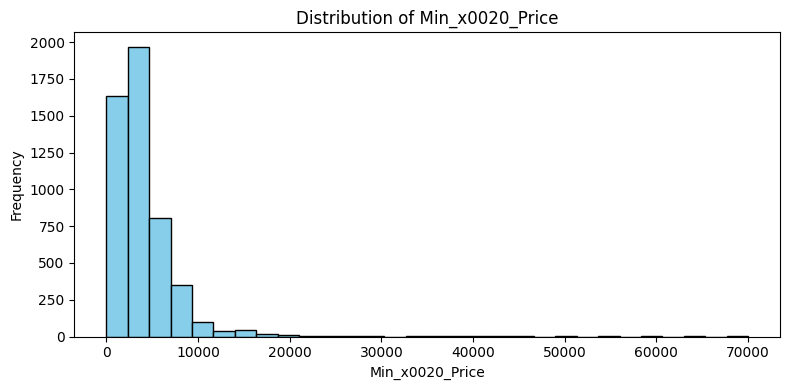

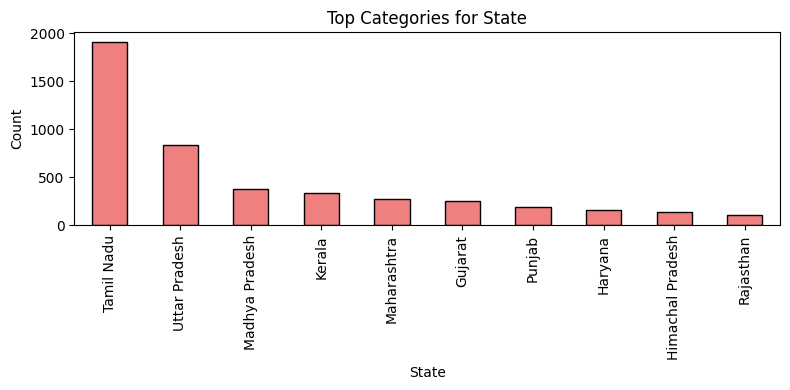

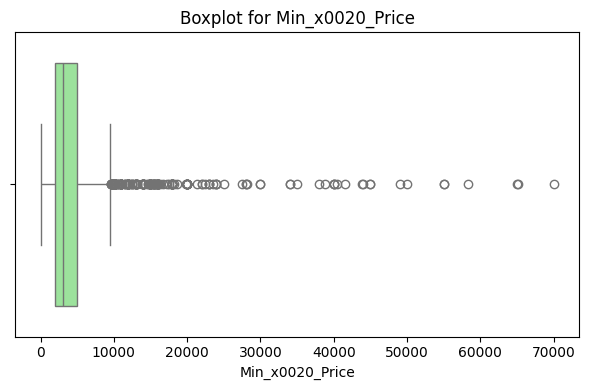

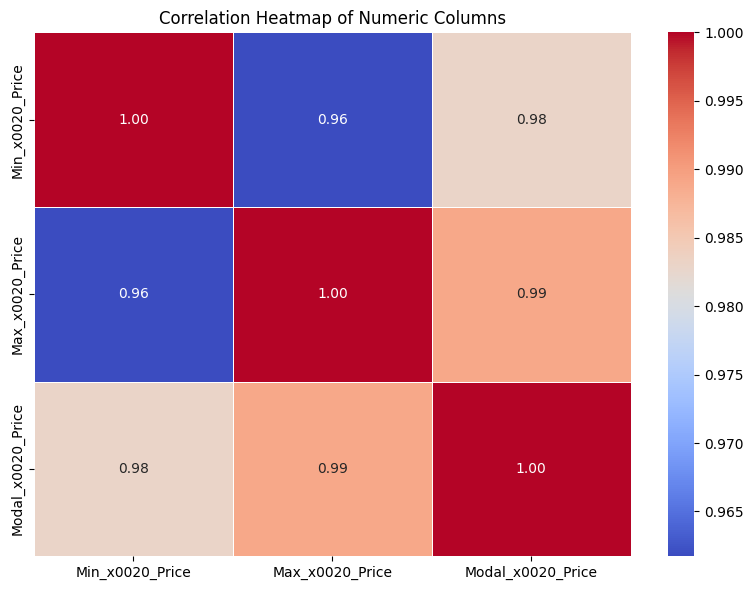

In [13]:
# STEP 4: Convert to Pandas for Visualization (Safe and Efficient)

from pyspark.sql.functions import rand
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

SAMPLE_SIZE = 5000  # smaller sample for stability (adjust as needed)

# Safer sampling: use Spark's .sample() instead of orderBy(rand())
total = df.count()
if total > SAMPLE_SIZE:
    fraction = float(SAMPLE_SIZE) / total
    print(f"Dataset has {total} rows — sampling ~{SAMPLE_SIZE} rows ({fraction:.4f} fraction) for visualization.")
    pdf_vis = df.sample(withReplacement=False, fraction=fraction, seed=42).limit(SAMPLE_SIZE).toPandas()
else:
    pdf_vis = df.limit(SAMPLE_SIZE).toPandas()

print("Pandas preview for visualization:")
display(pdf_vis.head())

# --- Visualization Section ---

numeric_cols = pdf_vis.select_dtypes(include=[np.number]).columns.tolist()
obj_cols = pdf_vis.select_dtypes(include=['object']).columns.tolist()

# 1️⃣ Histogram – Distribution of first numeric column
if numeric_cols:
    col = numeric_cols[0]
    plt.figure(figsize=(8, 4))
    plt.hist(pdf_vis[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# 2️⃣ Bar Chart – Top 10 categories for first object column
if obj_cols:
    col = obj_cols[0]
    top = pdf_vis[col].value_counts(dropna=False).head(10)
    plt.figure(figsize=(8, 4))
    top.plot(kind='bar', color='lightcoral', edgecolor='black')
    plt.title(f"Top Categories for {col}")
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# 3️⃣ Boxplot – Detect outliers in first numeric column
if len(numeric_cols) > 0:
    col = numeric_cols[0]
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=pdf_vis[col], color='lightgreen')
    plt.title(f"Boxplot for {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

# 4️⃣ Correlation Heatmap – Relationship between numeric columns
if len(numeric_cols) > 1:
    plt.figure(figsize=(8, 6))
    corr = pdf_vis[numeric_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap of Numeric Columns")
    plt.tight_layout()
    plt.show()


In [25]:
# STEP 5: Recommendations 
# Create simple rule-based recommendations based on common patterns.

from pyspark.sql.functions import col, count, isnan, length, desc, stddev, mean

# Thresholds
MISSING_THRESHOLD = 0.3
DOMINANCE_THRESHOLD = 0.9
SMALL_DATASET_THRESHOLD = 100
HIGH_CARDINALITY_THRESHOLD = 0.5   # 50% unique values
LOW_VARIANCE_THRESHOLD = 0.01      # numeric variance fraction
OUTLIER_STD_MULTIPLIER = 3

recommendations = []
total = df.count()

# 1. Missing values
for c, dtype in df.dtypes:
    if dtype in ('int', 'double', 'float', 'long', 'decimal'):
        missing_count = df.select(count(when(col(c).isNull() | isnan(col(c)), c))).collect()[0][0]
    else:
        missing_count = df.select(count(when(col(c).isNull() | (length(col(c)) == 0), c))).collect()[0][0]

    missing_frac = missing_count / total
    if missing_frac > MISSING_THRESHOLD:
        recommendations.append(f"Column '{c}' has {missing_frac:.1%} missing — consider imputing or improving data collection.")

# 2. Small dataset
if total < SMALL_DATASET_THRESHOLD:
    recommendations.append(f"Dataset only has {total} rows — consider collecting more data.")

# 3. Categorical dominance & high cardinality
for c, dtype in df.dtypes:
    if dtype == 'string':
        # dominance
        top_count = df.groupBy(c).count().orderBy(desc('count')).limit(1).collect()[0]['count']
        top_frac = top_count / total
        if top_frac > DOMINANCE_THRESHOLD:
            recommendations.append(f"Categorical column '{c}' is highly imbalanced (top category {top_frac:.1%}). Consider rebalancing.")
        # high cardinality
        unique_count = df.select(c).distinct().count()
        if unique_count / total > HIGH_CARDINALITY_THRESHOLD:
            recommendations.append(f"Categorical column '{c}' has high cardinality ({unique_count} unique values). Consider grouping or encoding strategies.")

# 4. Numeric low variance & outliers
for c, dtype in df.dtypes:
    if dtype in ('int', 'double', 'float', 'long', 'decimal'):
        stats = df.select(mean(col(c)).alias('mean'), stddev(col(c)).alias('std')).collect()[0]
        if stats['std'] is not None and stats['std'] == 0:
            recommendations.append(f"Numeric column '{c}' has zero variance — may not be informative.")
        # simple outlier check using mean ± 3*std
        if stats['std'] is not None and stats['std'] > 0:
            outlier_count = df.filter((col(c) < stats['mean'] - OUTLIER_STD_MULTIPLIER*stats['std']) | 
                                      (col(c) > stats['mean'] + OUTLIER_STD_MULTIPLIER*stats['std'])).count()
            if outlier_count / total > 0.01:
                recommendations.append(f"Numeric column '{c}' has {outlier_count} outliers (>3 std dev). Consider handling them.")

# 5. Duplicate rows
duplicate_count = df.count() - df.dropDuplicates().count()
if duplicate_count > 0:
    recommendations.append(f"Dataset has {duplicate_count} duplicate rows. Consider removing duplicates.")

# Print recommendations
if recommendations:
    print("Recommendations:")
    for r in recommendations:
        print("- ", r)
else:
    print("No automatic recommendations triggered.")

Recommendations:
-  Categorical column 'Arrival_Date' is highly imbalanced (top category 100.0%). Consider rebalancing.
-  Numeric column 'Min_x0020_Price' has 196 outliers (>3 std dev). Consider handling them.
-  Numeric column 'Max_x0020_Price' has 223 outliers (>3 std dev). Consider handling them.
-  Numeric column 'Modal_x0020_Price' has 208 outliers (>3 std dev). Consider handling them.
